In [97]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

In [3]:
#def reset_esn()の定義
#reset_esn()は一体何に使うのか？

def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [4]:
# 描画用のplot_generationの定義

def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [5]:
def coupled_system(t, state, a, b, c, A):
    X, Y, Z = state
    
    dXdt = -Y - Z + A * np.sin(t)
    dYdt = X + a * Y
    dZdt = b + Z * (X - c)
    
    return [dXdt, dYdt, dZdt]

# Rössler system parameters
a = 0.2
b = 0.2
c = 5.7
A = 1.0  # External force coefficient
initial_state = [0.0, 0.0, 0.0]  # Initial states for [X, Y, Z]
t_span = (0, 2510)  # Adjust time span as needed
t_eval = np.linspace(t_span[0], t_span[1], 25100)  # Adjust the number of points as needed

# Solve the coupled system
sol = solve_ivp(coupled_system, t_span, initial_state, args=(a, b, c, A), t_eval=t_eval, max_step=0.01)

In [7]:
# Extract 'X', 'Y', 'Z', and external force 'sin(t)' for learning
data = pd.DataFrame({
    'X': sol.y[0],
    'Y': sol.y[1],
    'Z': sol.y[2],
    'sin': np.sin(sol.t)
})

X = data.values

In [18]:
from reservoirpy.datasets import to_forecasting

train_len = 1000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:1000], y[:1000]
X_test, y_test = x[1000:2000], y[1000:2000]
X_gen_test, y_gen_test = x[2000:], y[2000:]

dataset = ((X_train, y_train), (X_test, y_test))

In [19]:
# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.14258024657972923
lr = 0.5516837456874331
ridge = 3.7433235003717447e-07
seed = 1234
sr = 0.1931498404234262

In [20]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [21]:
# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_val, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.0011392411452164266
R^2: 0.9997395328386979


In [41]:
# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

model = reset_esn()

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_val, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.0011392411452164266
R^2: 0.9997395328386979


In [43]:
seed_timesteps = 1000

warming_inputs = X_test

warming_out = model.run(warming_inputs, reset=True)  # warmup

In [61]:
nrmse(y_test[:, :1], predictions[:, :1])

0.024625465214068252

In [62]:
nrmse(warming_out[:, 1:2], y_test[:, 1:2])

0.017546771222541262

In [63]:
nrmse(warming_out[:, 2:3], y_test[:, 2:3])

0.008581826092719732

In [64]:
nrmse(warming_out[:, 3:4], y_test[:, 3:4])

0.0056497692497241275

In [82]:
sample = 1000

In [83]:
nrmse(warming_out[:, :1][-sample:], y_test[:, :1][-sample:])

0.024625465214068252

In [84]:
nrmse(warming_out[:, 1:2][-sample:], y_test[:, 1:2][-sample:])

0.017546771222541262

In [85]:
nrmse(warming_out[:, 2:3][-sample:], y_test[:, 2:3][-sample:])

0.008581826092719732

In [86]:
nrmse(warming_out[:, 3:4][-sample:], y_test[:, 3:4][-sample:])

0.0056497692497241275

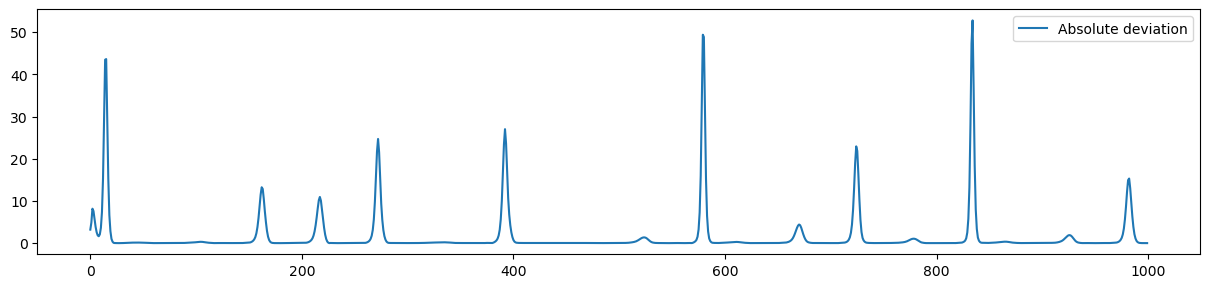

In [98]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.abs(warming_out[:, 2:3][:sample],  y_test[:, 3:4][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

In [48]:
nb_generations = 509

X_gen = np.zeros((nb_generations, 4))
y = warming_out[-1]

print(f"yの最後の値... {y}\n")
print(f"次の行\n")

for t in range(nb_generations):  # generation
    y = model(y_test[-1:])
    print(f"y = {y}\n")
    print(f"y_test= {y_gen_test[t]}\n")
    X_gen[t, :] = y

yの最後の値... [-5.57690108e+00  5.07100620e-03  5.95845945e-03 -8.69638810e-01]

次の行

y = [[-5.63282663 -0.55991665  0.00732827 -0.81604316]]

y_test= [-5.62883029 -0.56791122  0.01777554 -0.81571108]

y = [[-4.65942248 -0.37091437  0.40962308 -0.81912336]]

y_test= [-5.62343316 -1.14822573  0.01769102 -0.75388372]

y = [[-3.76366132 -0.44933116  0.35222753 -0.82750479]]

y_test= [-5.55298513 -1.73645713  0.0177102  -0.68452319]

y = [[-3.15838495 -0.71327615  0.06519033 -0.83216505]]

y_test= [-5.41630728 -2.32612915  0.01783325 -0.60832259]

y = [[-2.79956231 -1.00306139 -0.23702997 -0.83362291]]

y_test= [-5.21295263 -2.91055217  0.01806407 -0.52604335]

y = [[-2.60215293 -1.24135576 -0.47042104 -0.83348327]]

y_test= [-4.94323066 -3.48289422  0.01840968 -0.43850765]

y = [[-2.4987025  -1.41170548 -0.62583816 -0.83280184]]

y_test= [-4.60822392 -4.03625535  0.01888042 -0.34659016]

y = [[-2.44627356 -1.52386093 -0.72046454 -0.83207899]]

y_test= [-4.20979613 -4.56374487  0.01949041 -0.2

In [30]:
X_gen[:10]


array([[ -4.65216225,  -0.36093462,   0.40485952,  -0.81947344],
       [ -3.99480143,  -1.48374566,   2.62736452,  -0.76778229],
       [ -4.51098734,  -3.82813019,   1.62462838,  -0.6855962 ],
       [ -6.82192452,  -7.464242  ,  -2.37145247,  -0.59771495],
       [-10.81550844,  -9.26743217, -11.08789752,  -0.54390525],
       [-25.03187657,  -3.48758728, -12.45990114,  -0.75775597],
       [-31.10671257,  11.70418906,  -4.34884102,  -1.07530901],
       [ -4.44234168,  15.33346296,  21.21125342,  -1.22863793],
       [ -0.19937593,   6.2320895 ,  61.01459286,  -1.22105759],
       [ -4.00518189,  -0.85481325,  49.67712067,  -1.19651062]])

In [31]:
y_gen_test[:10]


array([[-5.62883029, -0.56791122,  0.01777554, -0.81571108],
       [-5.62343316, -1.14822573,  0.01769102, -0.75388372],
       [-5.55298513, -1.73645713,  0.0177102 , -0.68452319],
       [-5.41630728, -2.32612915,  0.01783325, -0.60832259],
       [-5.21295263, -2.91055217,  0.01806407, -0.52604335],
       [-4.94323066, -3.48289422,  0.01840968, -0.43850765],
       [-4.60822392, -4.03625535,  0.01888042, -0.34659016],
       [-4.20979613, -4.56374487,  0.01949041, -0.25120939],
       [-3.75059162, -5.05856049,  0.02025841, -0.15331842],
       [-3.23402604, -5.5140685 ,  0.02120901, -0.05389542]])